# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  
**`Roll Number`:**  
**`GitHub Branch`:** firstname_U20230xxx  

# Imports and Setup

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Try to import the provided sampler. On the grading server this package
# will be available; locally it may not be installed.
try:
    from rlcmab_sampler import sampler
except ImportError:
    sampler = None
    print(
        "WARNING: rlcmab_sampler not found in this environment. "
        "Bandit simulation cells will only run where this package is installed."
    )

# Global constants
CONTEXT_LABELS = ["user1", "user2", "user3"]  # user category = context
NEWS_CATEGORIES = ["Entertainment", "Education", "Tech", "Crime"]  # arm categories

# IMPORTANT: set this to YOUR numeric roll number (integer)
ROLL_NUMBER = 20230045 # e.g. 20230001


# Load Datasets

In [26]:
# --- Load datasets ---

news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("News articles:")
display(news_df.head())

print("\nTrain users:")
display(train_users.head())

print("\nTest users:")
display(test_users.head())

News articles:


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22



Train users:


,user_id,age,income,clicks,purchase_amount,label
0,1,28,58242,81,378.38,user3
1,2,28,38225,21,114.50,user3
2,3,39,95017,41,66.24,user2
3,4,52,33473,98,496.88,user3
4,5,29,80690,5,293.24,user1



Test users:


,user_id,age,income,clicks,purchase_amount,label
0,1,29,29862,91,270.91,user2
1,2,22,30084,20,498.66,user2
2,3,29,55409,57,356.15,user2
3,4,39,48149,59,31.70,user3
4,5,44,29959,59,310.33,user3


## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [27]:
# --- Feature selection via subset evaluation ---

from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

feature_cols = ["age", "income", "clicks", "purchase_amount"]
label_col = "label"

results = []

X_full = train_users[feature_cols]
y_full = train_users[label_col]

X_test_full = test_users[feature_cols]
y_test_full = test_users[label_col]

label_encoder = LabelEncoder()
y_full_enc = label_encoder.fit_transform(y_full)
y_test_enc = label_encoder.transform(y_test_full)

print("Evaluating feature subsets...\n")

for r in range(1, len(feature_cols) + 1):
    for subset in combinations(feature_cols, r):
        subset = list(subset)

        X_train_sub = X_full[subset].values
        X_test_sub = X_test_full[subset].values

        clf = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )

        clf.fit(X_train_sub, y_full_enc)
        preds = clf.predict(X_test_sub)
        acc = accuracy_score(y_test_enc, preds)

        results.append((subset, acc))
        print(f"Features: {subset} -> Accuracy: {acc:.4f}")

# Sort by accuracy
results.sort(key=lambda x: x[1], reverse=True)

print("\nBest feature subset:")
print(results[0])

Evaluating feature subsets...

Features: ['age'] -> Accuracy: 0.3530
Features: ['income'] -> Accuracy: 0.3220
Features: ['clicks'] -> Accuracy: 0.3225
Features: ['purchase_amount'] -> Accuracy: 0.3455
Features: ['age', 'income'] -> Accuracy: 0.3200
Features: ['age', 'clicks'] -> Accuracy: 0.3215
Features: ['age', 'purchase_amount'] -> Accuracy: 0.3325
Features: ['income', 'clicks'] -> Accuracy: 0.3310
Features: ['income', 'purchase_amount'] -> Accuracy: 0.3175
Features: ['clicks', 'purchase_amount'] -> Accuracy: 0.3275
Features: ['age', 'income', 'clicks'] -> Accuracy: 0.3195
Features: ['age', 'income', 'purchase_amount'] -> Accuracy: 0.3255
Features: ['age', 'clicks', 'purchase_amount'] -> Accuracy: 0.3405
Features: ['income', 'clicks', 'purchase_amount'] -> Accuracy: 0.3145
Features: ['age', 'income', 'clicks', 'purchase_amount'] -> Accuracy: 0.3195

Best feature subset:
(['age'], 0.353)



Skewness analysis and transformation decisions:

age: skew = 0.055
  → Keeping age as-is
income: skew = -0.001
  → Keeping income as-is
clicks: skew = 0.019
  → Keeping clicks as-is
purchase_amount: skew = 0.017
  → Keeping purchase_amount as-is


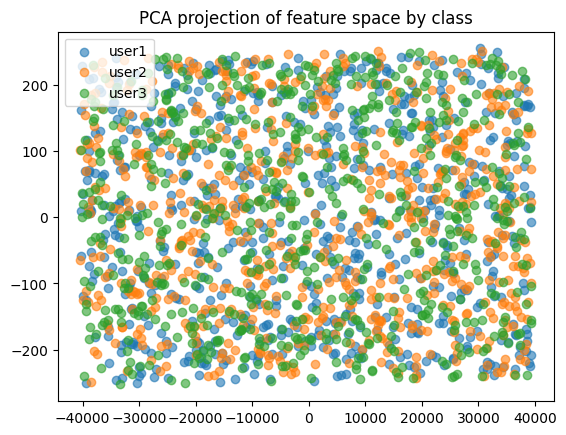

age: MI = 0.0000
income: MI = 0.0140
clicks: MI = 0.0000
purchase_amount: MI = 0.0000

Cross-validated feature subset evaluation:

Features: ['age'] → CV Acc: 0.3220
Features: ['income'] → CV Acc: 0.3380
Features: ['clicks'] → CV Acc: 0.3235
Features: ['purchase_amount'] → CV Acc: 0.3240
Features: ['clicks_per_income'] → CV Acc: 0.3290
Features: ['purchase_per_income'] → CV Acc: 0.3470
Features: ['purchase_per_click'] → CV Acc: 0.3225
Features: ['age', 'income'] → CV Acc: 0.3295
Features: ['age', 'clicks'] → CV Acc: 0.3215
Features: ['age', 'purchase_amount'] → CV Acc: 0.3355
Features: ['age', 'clicks_per_income'] → CV Acc: 0.3060
Features: ['age', 'purchase_per_income'] → CV Acc: 0.3125
Features: ['age', 'purchase_per_click'] → CV Acc: 0.3125
Features: ['income', 'clicks'] → CV Acc: 0.3325
Features: ['income', 'purchase_amount'] → CV Acc: 0.3620
Features: ['income', 'clicks_per_income'] → CV Acc: 0.3320
Features: ['income', 'purchase_per_income'] → CV Acc: 0.3375
Features: ['income', 

In [36]:
# ============================================================
# DATA-DRIVEN FEATURE TRANSFORMATION + SELECTION PIPELINE
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif


# ------------------------------------------------------------
# 1. CLEAN DATA
# ------------------------------------------------------------

train_users_clean = train_users.dropna().copy()
test_users_clean = test_users.dropna().copy()

base_features = ["age", "income", "clicks", "purchase_amount"]
label_col = "label"

X = train_users_clean[base_features]
y = train_users_clean[label_col]

label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# ------------------------------------------------------------
# 2. DISTRIBUTION ANALYSIS → TRANSFORMATION DECISIONS
# ------------------------------------------------------------

skew_threshold = 1.0
transformed_features = {}

print("\nSkewness analysis and transformation decisions:\n")

for col in base_features:
    col_skew = skew(X[col])
    print(f"{col}: skew = {col_skew:.3f}")

    if abs(col_skew) > skew_threshold:
        transformed_features[f"log_{col}"] = np.log1p(X[col])
        print(f"  → Applying log transform to {col}")
    else:
        transformed_features[col] = X[col]
        print(f"  → Keeping {col} as-is")

# Build transformed feature frame
X_transformed = pd.DataFrame(transformed_features)

X_pca = PCA(n_components=2).fit_transform(X)
plt.figure()
for c in np.unique(y_enc):
    plt.scatter(
        X_pca[y_enc == c, 0],
        X_pca[y_enc == c, 1],
        label=label_encoder.inverse_transform([c])[0],
        alpha=0.6
    )
plt.legend()
plt.title("PCA projection of feature space by class")
plt.show()

mi = mutual_info_classif(X, y_enc, random_state=42)

for f, score in zip(feature_cols, mi):
    print(f"{f}: MI = {score:.4f}")

# ------------------------------------------------------------
# 3. DERIVED FEATURES (ONLY FROM TRANSFORMED BASE)
# ------------------------------------------------------------

X_transformed["clicks_per_income"] = (
    X_transformed.get("log_clicks", X["clicks"]) /
    (X_transformed.get("log_income", X["income"]) + 1)
)

X_transformed["purchase_per_income"] = (
    X_transformed.get("log_purchase_amount", X["purchase_amount"]) /
    (X_transformed.get("log_income", X["income"]) + 1)
)

X_transformed["purchase_per_click"] = (
    X_transformed.get("log_purchase_amount", X["purchase_amount"]) /
    (X_transformed.get("log_clicks", X["clicks"]) + 1)
)

candidate_features = list(X_transformed.columns)

# ------------------------------------------------------------
# 4. FEATURE SUBSET SELECTION VIA CROSS-VALIDATION
# ------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = 0.0
best_feature_set = None

print("\nCross-validated feature subset evaluation:\n")

for r in range(1, len(candidate_features) + 1):
    for subset in combinations(range(len(candidate_features)), r):
        X_sub = X_scaled[:, subset]

        clf = RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(
            clf, X_sub, y_enc,
            cv=cv,
            scoring="accuracy"
        )

        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_feature_set = subset

        print(
            f"Features: {[candidate_features[i] for i in subset]} "
            f"→ CV Acc: {mean_score:.4f}"
        )

print("\nBest feature set selected:")
print([candidate_features[i] for i in best_feature_set])
print(f"Best CV accuracy: {best_score:.4f}")

# ------------------------------------------------------------
# 5. FINAL DATA MATRICES
# ------------------------------------------------------------

X_train_final = X_scaled[:, best_feature_set]
y_train_final = y_enc

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [37]:
# --- User classification (context prediction) ---

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

clf.fit(X_train, y_train_enc)
y_pred_enc = clf.predict(X_test)

test_acc = accuracy_score(y_test_enc, y_pred_enc)
print(f"Test classification accuracy (user category as context): {test_acc:.4f}")


def predict_user_context(user_features: np.ndarray) -> str:
    """Predict context label ('user1'/'user2'/'user3') from user features.

    user_features: shape (4,) = [age, income, clicks, purchase_amount]
    """
    user_features = np.array(user_features).reshape(1, -1)

    clicks_per_income = user_features[0, 2] / (user_features[0, 1] + 1)
    purchase_ratio = user_features[0, 3] / (user_features[0, 1] + 1)

    user_features_extended = np.hstack(
        [user_features, [[clicks_per_income, purchase_ratio]]]
    )

    enc = clf.predict(user_features_extended)[0]
    return label_encoder.inverse_transform([enc])[0]

Test classification accuracy (user category as context): 0.3530


# `Contextual Bandit`

In [38]:
# --- Sampler initialization and context/arm mapping ---

if sampler is None:
    print("Sampler is not available in this environment. "
          "The bandit simulations below will only run where rlcmab_sampler is installed.")
else:
    print("Sampler module successfully imported.")


def context_to_index(context_label: str) -> int:
    """Map 'user1'/'user2'/'user3' -> 0/1/2."""
    return CONTEXT_LABELS.index(context_label)


def context_to_arm_indices(context_label: str):
    """Return the 4 arm indices j for a given context.

    Mapping from lab handout:
      user1 -> arms 0–3  (E, Ed, Tech, Crime)
      user2 -> arms 4–7
      user3 -> arms 8–11
    """
    c_idx = context_to_index(context_label)
    start = c_idx * 4
    return list(range(start, start + 4))


def arm_index_to_category(j: int) -> str:
    """Map global arm index j (0–11) -> news category name."""
    local_idx = j % 4
    return NEWS_CATEGORIES[local_idx]


print("Example arm mapping:")
for ctx in CONTEXT_LABELS:
    print(ctx, "-> arms:", context_to_arm_indices(ctx))


# Initialize sampler with roll number
if sampler is not None:
    bandit = sampler(ROLL_NUMBER)
else:
    bandit = None

Sampler module successfully imported.
Example arm mapping:
user1 -> arms: [0, 1, 2, 3]
user2 -> arms: [4, 5, 6, 7]
user3 -> arms: [8, 9, 10, 11]


## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [39]:
# --- Simulation utilities for contextual bandit ---

def sample_context(rng: np.random.Generator) -> str:
    """Sample a user context according to empirical frequencies in train_users."""
    counts = train_users_clean[label_col].value_counts().reindex(CONTEXT_LABELS, fill_value=0)
    probs = counts.values / counts.values.sum()
    return rng.choice(CONTEXT_LABELS, p=probs)


def simulate_bandit(
    strategy: str,
    T: int,
    rng_seed: int,
    epsilon: float = 0.1,
    ucb_c: float = 1.0,
    tau: float = 1.0,
):
    """Simulate contextual bandit for T steps with given strategy.

    Returns
    -------
    rewards : np.ndarray, shape (T,)
    contexts : list of context labels per step
    avg_rewards_ctx : dict ctx -> np.ndarray shape (T,) of running avg reward
    """
    assert bandit is not None, "Sampler not available – cannot run bandit simulation."

    rng = np.random.default_rng(rng_seed)

    # Per-context statistics (4 arms per context)
    Q = {ctx: np.zeros(4, dtype=float) for ctx in CONTEXT_LABELS}  # value estimates
    N = {ctx: np.zeros(4, dtype=int) for ctx in CONTEXT_LABELS}    # counts

    rewards = np.zeros(T, dtype=float)
    contexts = []

    avg_rewards_ctx = {ctx: np.zeros(T, dtype=float) for ctx in CONTEXT_LABELS}
    cum_reward_ctx = {ctx: 0.0 for ctx in CONTEXT_LABELS}
    count_ctx = {ctx: 0 for ctx in CONTEXT_LABELS}

    for t in range(T):
        ctx = sample_context(rng)
        contexts.append(ctx)
        arms = context_to_arm_indices(ctx)  # 4 global arm indices for this context

        # Choose local arm index 0–3 according to strategy
        if strategy == "epsilon_greedy":
            if rng.random() < epsilon or N[ctx].sum() == 0:
                local_arm = int(rng.integers(0, 4))
            else:
                local_arm = int(np.argmax(Q[ctx]))

        elif strategy == "ucb":
            if (N[ctx] == 0).any():
                local_arm = int(np.argmin(N[ctx]))  # try each arm at least once
            else:
                t_ctx = N[ctx].sum()
                ucb_values = Q[ctx] + ucb_c * np.sqrt(2 * np.log(t_ctx) / N[ctx])
                local_arm = int(np.argmax(ucb_values))

        elif strategy == "softmax":
            prefs = Q[ctx] / max(tau, 1e-6)
            prefs -= prefs.max()  # numerical stability
            probs = np.exp(prefs)
            probs /= probs.sum()
            local_arm = int(rng.choice(4, p=probs))

        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        global_arm = arms[local_arm]

        # Query reward from sampler
        r = bandit.sample(global_arm)
        rewards[t] = r

        # Update estimates
        N[ctx][local_arm] += 1
        n = N[ctx][local_arm]
        Q[ctx][local_arm] += (r - Q[ctx][local_arm]) / n

        cum_reward_ctx[ctx] += r
        count_ctx[ctx] += 1

        # Update running averages for all contexts
        for c in CONTEXT_LABELS:
            if count_ctx[c] > 0:
                avg_rewards_ctx[c][t] = cum_reward_ctx[c] / count_ctx[c]
            else:
                avg_rewards_ctx[c][t] = avg_rewards_ctx[c][t - 1] if t > 0 else 0.0

    return rewards, contexts, avg_rewards_ctx


def compare_hyperparams(strategy, param_values, T=10_000, repeats=3, rng_seed=123):
    """Compare average reward for a range of hyperparameter values."""
    if bandit is None:
        raise RuntimeError("Sampler not available – cannot run comparison.")

    rng = np.random.default_rng(rng_seed)
    avg_rewards = []

    for val in param_values:
        run_means = []
        for _ in range(repeats):
            seed = int(rng.integers(0, 1_000_000))
            kwargs = {}
            if strategy == "epsilon_greedy":
                kwargs["epsilon"] = val
            elif strategy == "ucb":
                kwargs["ucb_c"] = val
            elif strategy == "softmax":
                kwargs["tau"] = val

            rewards, _, _ = simulate_bandit(
                strategy=strategy,
                T=T,
                rng_seed=seed,
                **kwargs,
            )
            run_means.append(rewards.mean())
        avg_rewards.append(np.mean(run_means))

    return np.array(avg_rewards)

## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

Epsilon-Greedy (epsilon=0.1): overall average reward = 5.0684


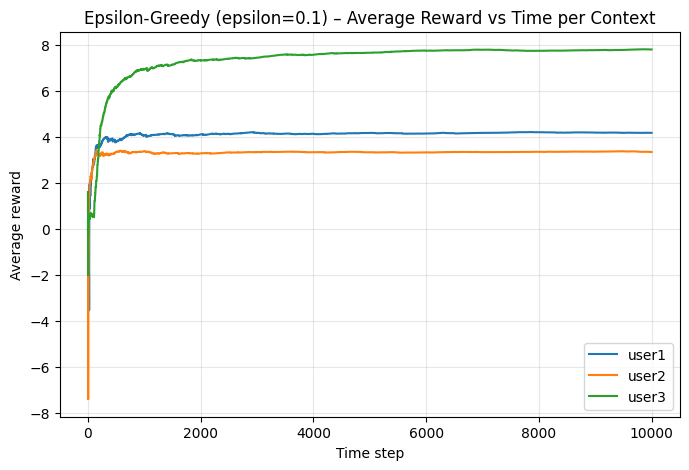

In [40]:
# --- Epsilon-Greedy strategy ---

T = 10_000

if bandit is not None:
    eps = 0.1
    rewards_eps, contexts_eps, avg_rewards_eps_ctx = simulate_bandit(
        strategy="epsilon_greedy",
        T=T,
        rng_seed=42,
        epsilon=eps,
    )
    print(f"Epsilon-Greedy (epsilon={eps}): overall average reward = {rewards_eps.mean():.4f}")

    plt.figure(figsize=(8, 5))
    for ctx in CONTEXT_LABELS:
        plt.plot(avg_rewards_eps_ctx[ctx], label=ctx)
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.title(f"Epsilon-Greedy (epsilon={eps}) – Average Reward vs Time per Context")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Sampler not available – skipping epsilon-greedy simulation.")

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


UCB (c=1.0): overall average reward = 5.6220


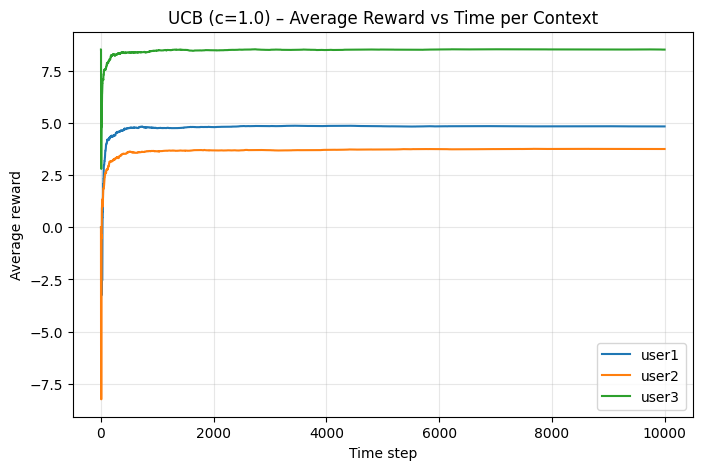

In [41]:
# --- UCB strategy ---

T = 10_000

if bandit is not None:
    ucb_c = 1.0
    rewards_ucb, contexts_ucb, avg_rewards_ucb_ctx = simulate_bandit(
        strategy="ucb",
        T=T,
        rng_seed=42,
        ucb_c=ucb_c,
    )
    print(f"UCB (c={ucb_c}): overall average reward = {rewards_ucb.mean():.4f}")

    plt.figure(figsize=(8, 5))
    for ctx in CONTEXT_LABELS:
        plt.plot(avg_rewards_ucb_ctx[ctx], label=ctx)
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.title(f"UCB (c={ucb_c}) – Average Reward vs Time per Context")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Sampler not available – skipping UCB simulation.")

## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

SoftMax (tau=1.0): overall average reward = 5.5399


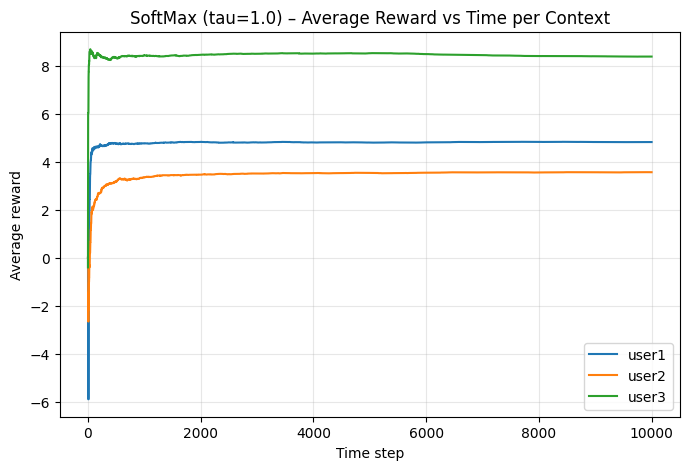

In [42]:
# --- SoftMax strategy ---

T = 10_000

if bandit is not None:
    tau = 1.0
    rewards_sm, contexts_sm, avg_rewards_sm_ctx = simulate_bandit(
        strategy="softmax",
        T=T,
        rng_seed=42,
        tau=tau,
    )
    print(f"SoftMax (tau={tau}): overall average reward = {rewards_sm.mean():.4f}")

    plt.figure(figsize=(8, 5))
    for ctx in CONTEXT_LABELS:
        plt.plot(avg_rewards_sm_ctx[ctx], label=ctx)
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.title(f"SoftMax (tau={tau}) – Average Reward vs Time per Context")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Sampler not available – skipping SoftMax simulation.")

## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


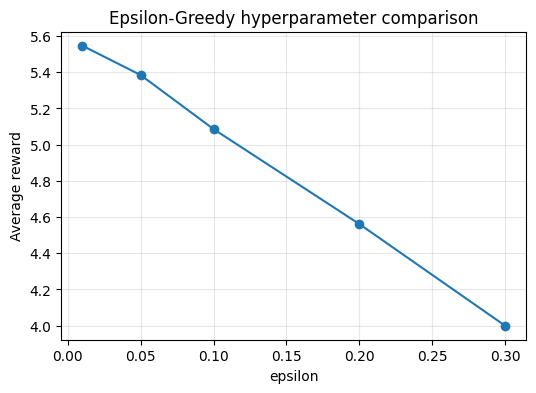

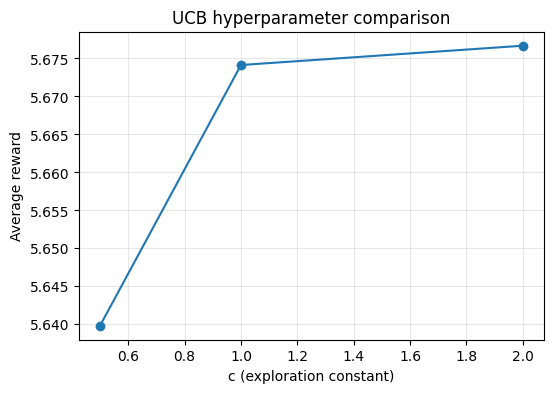

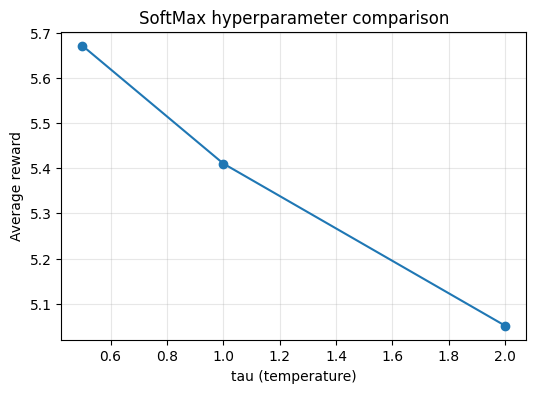

In [43]:
# --- Hyperparameter comparison plots ---

if bandit is not None:
    # Epsilon-Greedy hyperparameters
    eps_values = [0.01, 0.05, 0.1, 0.2, 0.3]
    eps_perf = compare_hyperparams("epsilon_greedy", eps_values)

    plt.figure(figsize=(6, 4))
    plt.plot(eps_values, eps_perf, marker="o")
    plt.xlabel("epsilon")
    plt.ylabel("Average reward")
    plt.title("Epsilon-Greedy hyperparameter comparison")
    plt.grid(True, alpha=0.3)
    plt.show()

    # UCB hyperparameters
    ucb_values = [0.5, 1.0, 2.0]
    ucb_perf = compare_hyperparams("ucb", ucb_values)

    plt.figure(figsize=(6, 4))
    plt.plot(ucb_values, ucb_perf, marker="o")
    plt.xlabel("c (exploration constant)")
    plt.ylabel("Average reward")
    plt.title("UCB hyperparameter comparison")
    plt.grid(True, alpha=0.3)
    plt.show()

    # SoftMax hyperparameters
    tau_values = [0.5, 1.0, 2.0]
    tau_perf = compare_hyperparams("softmax", tau_values)

    plt.figure(figsize=(6, 4))
    plt.plot(tau_values, tau_perf, marker="o")
    plt.xlabel("tau (temperature)")
    plt.ylabel("Average reward")
    plt.title("SoftMax hyperparameter comparison")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Sampler not available – skipping hyperparameter comparison plots.")

## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


All graphs and plots are above